In [1]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os

# Set the CUDA flag
cuda_flag = True
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
criterion = torch.nn.MSELoss()
epoches = 2000

losses_ = np.zeros((epoches,))

trn_snr_ = np.zeros((epoches,))
tst_snr_ = np.zeros((epoches,))

file_path = 'images/'
file_name = 'house'

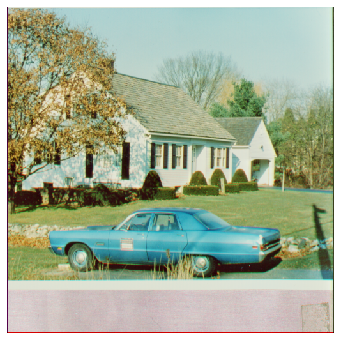

In [2]:
rgb = imread('house.tiff');
rgb = rgb.copy()
trn_im_torch = (torch.from_numpy(rgb)/256.0).type(torch.FloatTensor)
#trn_im_torch = torch.from_numpy(rgb)
figure(figsize=(6,6)); imshow(trn_im_torch); axis('off');
plt.savefig(file_path+'2D_'+file_name+'_gt.pdf', bbox_inches='tight', pad_inches=0)

In [3]:
def srank_l12(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    # Determine the threshold (from matrix rank)
    sr2 = (s*s).sum()/s[0]/s[0]
    sr1 = s.sum()/s[0]
    return sr1,sr2

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def rff_embedding(x, b):
    rffemb = torch.cat((torch.sin((2.*np.pi*x) @ b.T),torch.cos((2.*np.pi*x) @ b.T)),1)
    rffemb = rffemb/(rffemb.norm(dim=1).max())
    return rffemb

def rbf_embedding(x,dic1,dic2,sig1,sig2):
    rbfemb1 = (-0.5*(x[:,0].unsqueeze(1)-dic1)**2/(sig1**2)).exp()
    rbfemb2 = (-0.5*(x[:,1].unsqueeze(1)-dic2)**2/(sig2**2)).exp()
    rbfemb = torch.cat([rbfemb1,rbfemb2],1)
    rbfemb = rbfemb/(rbfemb.norm(dim=1).max())
    return rbfemb

def norm_func(x):
    # Flatten the data 
    #x = x.flatten(1,3)
    
    # Normalize for gain and bias
    #y = x-x.mean(1).unsqueeze(-1)
    y = x/x.norm(dim=1).unsqueeze(-1)    
    return y

def mutual_coherence(model,name):
    
    std = model.state_dict().copy()
    param = std[name]
    W = norm_func(param)
    
    output = W@W.T
    # Remove diagonal
    eye = torch.eye(W.shape[0]).cuda()
    output = output * (1.0 - eye)

    # Compute sum/max
    mutual_coherence = output.max()
    frame_potential = (output*output).sum()
    return mutual_coherence,frame_potential


def plot_data(x):
    figure()
    plot(losses_)
    ylabel('loss')
    xlabel('epochs')
    
    figure()
    plot(trn_snr_,label='train')
    plot(tst_snr_,label='test')
    ylabel('SNR')
    xlabel('epochs')
    legend()
    
    if x==0: return 0
        
    figure()
    for i in range(4):
        plot(trn_esr2_[i],label='e{}'.format(i+1)) 
    legend()
    ylabel('L2 Stable Rank')
    xlabel('5 epochs')
    
    figure()
    for i in range(4):
        plot(trn_esr1_[i],label='e{}'.format(i+1)) 
    legend()
    ylabel('L1 Stable Rank')
    xlabel('5 epochs')
    
    figure()
    for i in range(4):
        plot(trn_sp_[i],label='fc{}'.format(i+1)) 
    legend()
    ylabel('sparsity')
    xlabel('5 epochs')
    
    figure()
    for i in range(4):
        plot(trn_mc_[i],label='fc{}'.format(i+1))
    legend()
    ylabel('mutual coherence')
    xlabel('5 epochs')
    
    figure()
    for i in range(4):
        plot(trn_fp_[i],label='fc{}'.format(i+1))
    legend()
    ylabel('frame potential')
    xlabel('5 epochs')

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

width = 256

# Here define the CNN auto-encoder
class DNN(nn.Module):
    def __init__(self,input_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fco = nn.Linear(width, 3)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    def forward(self, x):
        x1 = self.fc1(x)
        e1 = self.relu(x1)
        x2 = self.fc2(e1)
        e2 = self.relu(x2)
        x3 = self.fc3(e2)
        e3 = self.relu(x3)
        x4 = self.fc4(e3)
        e4 = self.relu(x4)
        x = self.fco(e4)
        out = self.sig(x)
        return out,e4,e3,e2,e1
    def name(self):
        return "DNN"

In [5]:
sample_d=1

In [6]:
sigs = [0.07]
Ns = len(sigs)
Nt = 1
tst_psnr_b=np.zeros((Ns,Nt))

RES = 256
ez = 1000
#dic = torch.rand((ez,2))

x1 = np.linspace(0, 1, 2*RES+1)[:-1]
all_data = np.stack(np.meshgrid(x1,x1), axis=-1)

train_data = torch.from_numpy(all_data[::2,::2*sample_d].reshape(-1,2)).type(torch.FloatTensor)

test_data = torch.from_numpy(all_data[1::2,sample_d::2*sample_d].reshape(-1,2)).type(torch.FloatTensor)

train_label = trn_im_torch.squeeze()[::2,::2*sample_d].reshape(-1,3).type(torch.FloatTensor)
test_label = trn_im_torch.squeeze()[1::2,sample_d::2*sample_d].reshape(-1,3).type(torch.FloatTensor)

for ss in range(Ns):
    sig0 = sigs[ss]
    for tt in range(Nt):
        
        start_time = time.time()
        # Initialize classification model to learn
        model = DNN(ez).cuda()

        # Set the optimization
        optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)

        dic1 = torch.zeros((1,int(ez/2)))
        for i in range(int(ez/2)):
            dic1[0,i] = 2*i/ez

        dic2 = torch.zeros((1,int(ez/2)))
        for i in range(int(ez/2)):
            dic2[0,i] = 2*i/ez

        sig1 = sig0
        sig2 = sig0

        xt, yt = rbf_embedding(train_data,dic1,dic2,sig1,sig2).cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = rbf_embedding(test_data,dic1,dic2,sig1,sig2).cuda(),test_label.cuda()

        #n = 0
        for epoch in range(epoches):
            model.train()
            
            sum_loss = 0 # Set the average loss to zero
            optimizer.zero_grad()

            out,e4,e3,e2,e1 = model(xt)
            loss = criterion(out, yt)
            loss.backward()
            sum_loss = loss.item() # Store the loss
            optimizer.step()

            #es = [e1.detach().cpu(), e2.detach().cpu(), e3.detach().cpu(), e4.detach().cpu()]
            #losses_[epoch] = sum_loss

            model.eval()
            #if (epoch+1)%d == 0:
            #    for i in range(4):
            #        trn_esr1_[i][n],trn_esr2_[i][n] = srank_l12(es[i])
            #        trn_sp_[i][n] = (es[i]>0).type(torch.FloatTensor).mean()

            #    trn_mc_[0][n],trn_fp_[0][n] = mutual_coherence(model,'fc1.weight')
            #    trn_mc_[1][n],trn_fp_[1][n] = mutual_coherence(model,'fc2.weight')
            #    trn_mc_[2][n],trn_fp_[2][n] = mutual_coherence(model,'fc3.weight')
            #    trn_mc_[3][n],trn_fp_[3][n] = mutual_coherence(model,'fc4.weight')

            #    n = n+1
            if epoches>1850:
                #trn_snr_[epoch] = psnr_func(model(xt)[0],yt)
                tst_snr_[epoch] = psnr_func(model(xts)[0],yts)
        
        tst_psnr_b[ss,tt] = np.mean(tst_snr_[-100:])
        print("==>>> b: %g, t: %g--- , test psnr: %g---, time:%g seconds ---" 
                % (sig0, tt,tst_psnr_b[ss,tt],time.time() - start_time))
        

==>>> b: 0.07, t: 0--- , test psnr: 25.006---, time:75.7267 seconds ---


print(srank_l12(xt))
(u,s1,v) = torch.svd(xt.detach().cpu())
plot(s1)

plot_data(1)

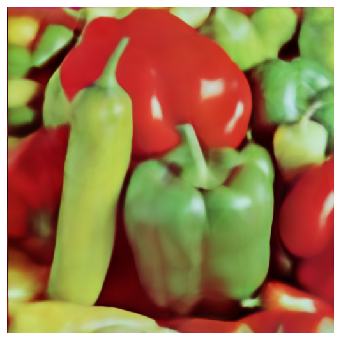

In [7]:
train_data = torch.from_numpy(all_data.reshape(-1,2)).type(torch.FloatTensor)
train_emb = rbf_embedding(train_data,dic1,dic2,sig1,sig2).cuda()
img = model(train_emb)[0].detach().cpu().reshape(512,512,3)
figure(figsize=(6,6)); imshow(img); axis('off'); 
plt.savefig(file_path+'2D_'+file_name+'_'+str(sigs)+'.pdf', bbox_inches='tight', pad_inches=0)

get_img(model,'b',512,-0.5,1.5)

In [6]:
sigs = [0.003]
Ns = len(sigs)
Nt = 1
tst_psnr_b=np.zeros((Ns,Nt))

RES = 256
ez = 1000
#dic = torch.rand((ez,2))

x1 = np.linspace(0, 1, 2*RES+1)[:-1]
all_data = np.stack(np.meshgrid(x1,x1), axis=-1)

train_data = torch.from_numpy(all_data[::2,::2*sample_d].reshape(-1,2)).type(torch.FloatTensor)

test_data = torch.from_numpy(all_data[1::2,sample_d::2*sample_d].reshape(-1,2)).type(torch.FloatTensor)

train_label = trn_im_torch.squeeze()[::2,::2*sample_d].reshape(-1,3).type(torch.FloatTensor)
test_label = trn_im_torch.squeeze()[1::2,sample_d::2*sample_d].reshape(-1,3).type(torch.FloatTensor)

for ss in range(Ns):
    sig0 = sigs[ss]
    for tt in range(Nt):
        
        start_time = time.time()
        # Initialize classification model to learn
        model = DNN(ez).cuda()

        # Set the optimization
        optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)

        dic1 = torch.zeros((1,int(ez/2)))
        for i in range(int(ez/2)):
            dic1[0,i] = 2*i/ez

        dic2 = torch.zeros((1,int(ez/2)))
        for i in range(int(ez/2)):
            dic2[0,i] = 2*i/ez

        sig1 = sig0
        sig2 = sig0

        xt, yt = rbf_embedding(train_data,dic1,dic2,sig1,sig2).cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = rbf_embedding(test_data,dic1,dic2,sig1,sig2).cuda(),test_label.cuda()

        #n = 0
        for epoch in range(epoches):
            model.train()
            
            sum_loss = 0 # Set the average loss to zero
            optimizer.zero_grad()

            out,e4,e3,e2,e1 = model(xt)
            loss = criterion(out, yt)
            loss.backward()
            sum_loss = loss.item() # Store the loss
            optimizer.step()

            #es = [e1.detach().cpu(), e2.detach().cpu(), e3.detach().cpu(), e4.detach().cpu()]
            #losses_[epoch] = sum_loss

            model.eval()
            #if (epoch+1)%d == 0:
            #    for i in range(4):
            #        trn_esr1_[i][n],trn_esr2_[i][n] = srank_l12(es[i])
            #        trn_sp_[i][n] = (es[i]>0).type(torch.FloatTensor).mean()

            #    trn_mc_[0][n],trn_fp_[0][n] = mutual_coherence(model,'fc1.weight')
            #    trn_mc_[1][n],trn_fp_[1][n] = mutual_coherence(model,'fc2.weight')
            #    trn_mc_[2][n],trn_fp_[2][n] = mutual_coherence(model,'fc3.weight')
            #    trn_mc_[3][n],trn_fp_[3][n] = mutual_coherence(model,'fc4.weight')

            #    n = n+1
            if epoches>1850:
                #trn_snr_[epoch] = psnr_func(model(xt)[0],yt)
                tst_snr_[epoch] = psnr_func(model(xts)[0],yts)
        
        tst_psnr_b[ss,tt] = np.mean(tst_snr_[-100:])
        print("==>>> b: %g, t: %g--- , test psnr: %g---, time:%g seconds ---" 
                % (sig0, tt,tst_psnr_b[ss,tt],time.time() - start_time))
        

==>>> b: 0.003, t: 0--- , test psnr: 23.1375---, time:75.3115 seconds ---


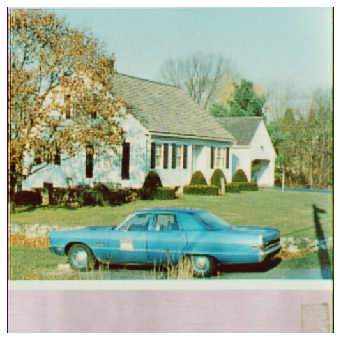

In [7]:
train_data = torch.from_numpy(all_data.reshape(-1,2)).type(torch.FloatTensor)
train_emb = rbf_embedding(train_data,dic1,dic2,sig1,sig2).cuda()
img = model(train_emb)[0].detach().cpu().reshape(512,512,3)
figure(figsize=(6,6)); imshow(img); axis('off'); 
plt.savefig(file_path+'2D_'+file_name+'_'+str(sigs)+'.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
sigs = [0.001]
Ns = len(sigs)
Nt = 1
tst_psnr_b=np.zeros((Ns,Nt))

RES = 256
ez = 1000
#dic = torch.rand((ez,2))

x1 = np.linspace(0, 1, 2*RES+1)[:-1]
all_data = np.stack(np.meshgrid(x1,x1), axis=-1)

train_data = torch.from_numpy(all_data[::2,::2*sample_d].reshape(-1,2)).type(torch.FloatTensor)

test_data = torch.from_numpy(all_data[1::2,sample_d::2*sample_d].reshape(-1,2)).type(torch.FloatTensor)

train_label = trn_im_torch.squeeze()[::2,::2*sample_d].reshape(-1,3).type(torch.FloatTensor)
test_label = trn_im_torch.squeeze()[1::2,sample_d::2*sample_d].reshape(-1,3).type(torch.FloatTensor)

for ss in range(Ns):
    sig0 = sigs[ss]
    for tt in range(Nt):
        
        start_time = time.time()
        # Initialize classification model to learn
        model = DNN(ez).cuda()

        # Set the optimization
        optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)

        dic1 = torch.zeros((1,int(ez/2)))
        for i in range(int(ez/2)):
            dic1[0,i] = 2*i/ez

        dic2 = torch.zeros((1,int(ez/2)))
        for i in range(int(ez/2)):
            dic2[0,i] = 2*i/ez

        sig1 = sig0
        sig2 = sig0

        xt, yt = rbf_embedding(train_data,dic1,dic2,sig1,sig2).cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = rbf_embedding(test_data,dic1,dic2,sig1,sig2).cuda(),test_label.cuda()

        #n = 0
        for epoch in range(epoches):
            model.train()
            
            sum_loss = 0 # Set the average loss to zero
            optimizer.zero_grad()

            out,e4,e3,e2,e1 = model(xt)
            loss = criterion(out, yt)
            loss.backward()
            sum_loss = loss.item() # Store the loss
            optimizer.step()

            #es = [e1.detach().cpu(), e2.detach().cpu(), e3.detach().cpu(), e4.detach().cpu()]
            #losses_[epoch] = sum_loss

            model.eval()
            #if (epoch+1)%d == 0:
            #    for i in range(4):
            #        trn_esr1_[i][n],trn_esr2_[i][n] = srank_l12(es[i])
            #        trn_sp_[i][n] = (es[i]>0).type(torch.FloatTensor).mean()

            #    trn_mc_[0][n],trn_fp_[0][n] = mutual_coherence(model,'fc1.weight')
            #    trn_mc_[1][n],trn_fp_[1][n] = mutual_coherence(model,'fc2.weight')
            #    trn_mc_[2][n],trn_fp_[2][n] = mutual_coherence(model,'fc3.weight')
            #    trn_mc_[3][n],trn_fp_[3][n] = mutual_coherence(model,'fc4.weight')

            #    n = n+1
            if epoches>1850:
                #trn_snr_[epoch] = psnr_func(model(xt)[0],yt)
                tst_snr_[epoch] = psnr_func(model(xts)[0],yts)
        
        tst_psnr_b[ss,tt] = np.mean(tst_snr_[-100:])
        print("==>>> b: %g, t: %g--- , test psnr: %g---, time:%g seconds ---" 
                % (sig0, tt,tst_psnr_b[ss,tt],time.time() - start_time))
        

==>>> b: 0.001, t: 0--- , test psnr: 20.5813---, time:70.0093 seconds ---


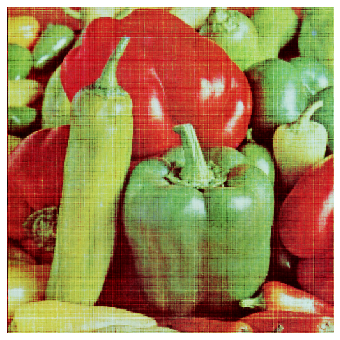

In [11]:
train_data = torch.from_numpy(all_data.reshape(-1,2)).type(torch.FloatTensor)
train_emb = rbf_embedding(train_data,dic1,dic2,sig1,sig2).cuda()
img = model(train_emb)[0].detach().cpu().reshape(512,512,3)
figure(figsize=(6,6)); imshow(img); axis('off'); 
plt.savefig(file_path+'2D_'+file_name+'_'+str(sigs)+'.pdf', bbox_inches='tight', pad_inches=0)